# P411 - Assignment 5
Kristi Webb, Oct 16 2015

github k-a-webb

In [287]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

## Q1: Distribution of power spectral estimates

<div style='background:#F0F0F0'>**1** You **may** use `matplotlib.mlab.psd` for the following question, but you had best use it correctly!

Using normally distributed random noise time series of length $N=2048$, show using a Monte Carlo analysis and by comparison to the theoretical probability distribution functions that:  
</div>

   1. The raw spectral estimate is indeed distributed as $\chi^2_2$.
   2. Show that block averaging with no overlap is distributed as $\chi^2_{2N_{blocks}}$.
   3. Show that block averaging with 50% overlap Hanning windows is distributed as $\chi^2_{2N_{blocks}}$.

<div style='background:#F0F0F0'>You can choose your block length, but making it an integer divisor of 2048 will make your life a lot easier.  Show that as $N_{blocks}$ is increased the variance drops (i.e. the distribution of the spectral estimates gets tighter).</div>


<div style='background:#F0F0F0'>HINT: for this time series the individual frequency estimates are indipendent samples of the distribution, so you can use them in compiling your distributions.</div>

<div style='background:#F0F0F0'>HINT: To get the pdf of the $\chi^2_\nu$ distribution correct, you need to "scale" by $\nu^{-1}$ where $\nu$ are the degrees of freedom.</div>

<div style='background:#F0F0F0'>HINT: for good presentation, make your histograms have the same bin sizes, and compare the distributions for all three cases on the same plot.</div>

<hr>

# Raw spectral estimate

In [288]:
N = 2048

def normal_dist(N):
    x = np.random.rand(N)
    x -= np.mean(x)  # to normalize
    return x   

def pow_spec(x, fs=1, plot=False):
    X = np.fft.fft(x)/fs
    N=len(x)
    T = N/fs
    Gxx = (2./T)*np.real(np.conj(X[:N/2])*X[:N/2])
    f = np.arange(N/2.)/T
    if plot:
        plt.loglog(f,Gxx)   
    return Gxx, f         

In [289]:
# Check that mlab.psd returns the extected power spectrum
x = normal_dist(N)
Gxx, f = pow_spec(x)
Pxx, ff = mlab.psd(x, NFFT=len(x), Fs=1) # these parameters seem to work

#plt.plot(f, Gxx, '-g') ; plt.plot(ff, Pxx, '-b')

In [290]:
NN = 1000
df = 2.

Gxs = np.zeros((NN,N/2)) 

for ind in range(NN):
    x = normal_dist(N)
    Gxx, f = pow_spec(x)
    #Gxx, f = mlab.psd(x, NFFT=len(x), Fs=1)
    Gxs[ind,:] = Gxx  

Gm = np.mean(Gxs, axis=0)

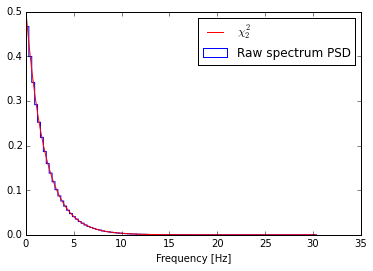

In [291]:
Gxsf = Gxs.flat   # Take all iterations of the power spectrum calculated in the Monte Carlo simulation
Gxsfn = (Gxsf)/np.std(Gxsf) * df  # Normalize

nn, bins, patches = plt.hist(Gxsfn, 100, normed=True, histtype='step', label='Raw spectrum PSD')
chi2 = stats.chi2.pdf(bins, df=df)
plt.plot(bins, chi2, '-r', label=r'$\chi^2_2$')
plt.xlabel('Frequency [Hz]') ; plt.legend() ; plt.show()

# Block averging

In [292]:
NN = 1000
nblock = 8
if N % nblock != 0:
    print N % nblock # Catch the case where there are extra/missing points
    
df = 2. * nblock
Nblock = N / nblock

n = Nblock/2+1
Gblocks = np.empty(NN*n)

for i in range(NN):
    x = normal_dist(N)
    a = i*n ; b = a+n  # bounds of the data set
    Gblock, fblock = mlab.psd(x, Fs=1, NFFT=Nblock, window=mlab.window_none)  #divide into 8 blocks
    Gblocks[a:b] = Gblock/np.mean(Gblock)

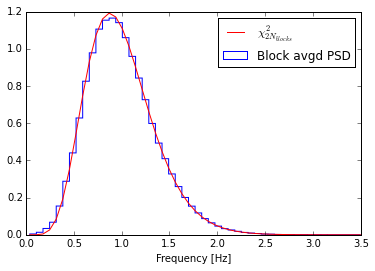

In [293]:
nn, bins, patches = plt.hist(Gblocks, bins=50, normed=True, histtype='step', label='Block avgd PSD')
chi2 = stats.chi2.pdf(bins*df, df)*df

plt.plot(bins, chi2, '-r', label=r'$\chi^2_{2N_{blocks}}$')
plt.xlabel('Frequency [Hz]') ; plt.legend() ; plt.show()

# block averaging with 50% overlap Hanning windows

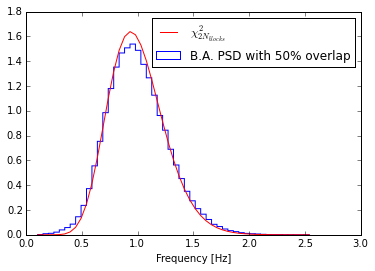

In [303]:
Gblocks = np.empty(NN*n)

df = nblock * 2 * 2

for i in range(NN):
    x = normal_dist(N)
    a = i*n ; b = a+n  # bounds of the data set
    Gblock, fblock = mlab.psd(x, Fs=1, NFFT=Nblock, noverlap=Nblock/2)  #divide into 8 blocks
    Gblocks[a:b] = Gblock/np.mean(Gblock)
    
nn, bins, patches = plt.hist(Gblocks, bins=50, normed=True, histtype='step', label='B.A. PSD with 50% overlap')
chi2 = stats.chi2.pdf(bins*df, df)*df

plt.plot(bins, chi2, '-r', label=r'$\chi^2_{2N_{blocks}}$')
plt.xlabel('Frequency [Hz]') ; plt.legend() ; plt.show()    

<hr>
<div style='background:#F0F0F0'>**2**  For the Hanning window estimate, what fits better: $2N_{blocks}$ degrees of freedom or $18N_{blocks}/11$ degrees of freedom (the correct theoretical value)?  Its OK to evaluate by eye.</div>
<hr>

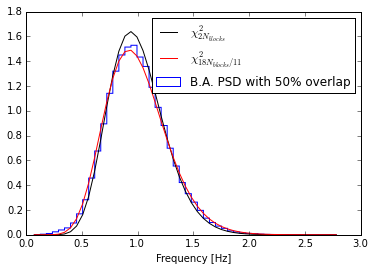

In [300]:
nn, bins, patches = plt.hist(Gblocks, bins=50, normed=True, histtype='step', label='B.A. PSD with 50% overlap')

df = 2 * nblock * 2
chi2_2N = stats.chi2.pdf(bins*df, df)*df
plt.plot(bins, chi2_2N, '-k', label=r'$\chi^2_{2N_{blocks}}$')

df = 18./11. * nblock * 2
chi2_18N11 = stats.chi2.pdf(bins*df, df)*df
plt.plot(bins, chi2_18N11, '-r', label=r'$\chi^2_{18N_{blocks}/11}$')

plt.xlabel('Frequency [Hz]') ; plt.legend() ; plt.show()    

It appears that the chi^2 of 18N/11 is a better estimate of the data, but 2N is still a good approximation

## Q2: Spectra of a "red-noise" signal

<div style='background:#F0F0F0'> **1** Load in the Deep Cove hourly data, and compute the power spectra using some reasonable value for $N_{FFT}$, and comment on the effect of applying the Hanning window to not applying it to the spectral leakage.</div>
<hr>

In [266]:
hourdata=np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/AllHourly.txt')[[6,28],2:]
dc = hourdata[0,:]
dc=dc[np.isfinite(dc)]

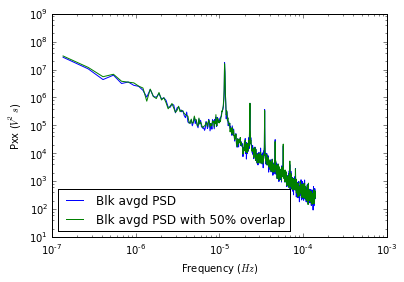

In [262]:
Nfft = 2048
ts = 1./3600.

Gxx, f = mlab.psd(dc, Fs=ts, NFFT=Nfft, window=mlab.window_none)
GxxH, f = mlab.psd(dc, Fs=ts, NFFT=Nfft, noverlap=Nfft/2, window=mlab.window_none)

plt.loglog(f, Gxx, label='Blk avgd PSD')
plt.loglog(f, GxxH, label='Blk avgd PSD with 50% overlap')
plt.xlabel('Frequency ($Hz$)') ; plt.ylabel(r'Pxx ($V^2 s$)') ; plt.legend(loc=3) ; plt.show()

Including the Hanning windowing reduces the noise in the spectrum

<hr>
<div style='background:#F0F0F0'> **2** Now do the same thing to the intergal of the Deep Cove data with time: $$y(t)=\int_o^t x(t')\ \mathrm{d}t'$$  This is obviously a silly thing to do, but compare the spectra and comment on the difference between the Hanning window and the non-Hanning windowed data.  </div>
<hr>

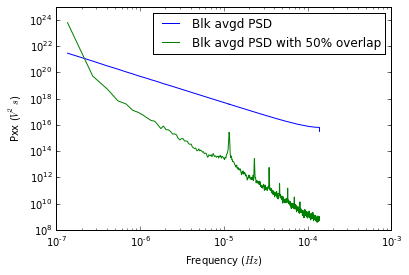

In [285]:
Nfft = 2048
ts = 1./3600

x = np.cumsum(dc) / ts

Gxx, f = mlab.psd(x, Fs=ts, NFFT=Nfft, window=mlab.window_none)
GxxH, f = mlab.psd(x, Fs=ts, NFFT=Nfft, noverlap=Nfft/2.)

plt.loglog(f, Gxx, label='Blk avgd PSD')
plt.loglog(f, GxxH, label='Blk avgd PSD with 50% overlap')
plt.xlabel('Frequency ($Hz$)') ; plt.ylabel(r'Pxx ($V^2 s$)') ; plt.legend(loc=1) ; plt.show()

The variance has been decreased by the Hanning windowing (i.e. the variance is the area under the curve) which means that the distribution of the spectral estimate is tightened. The Hanning windowing also is better at smooting the noise with respect to the peaks (ie signal-to-noise has been improved).